# Objekterkennung IntSys

In diesem Projekt sollen Objekte auf einem Drehteller mithilfe eines Ultraschall Sensors (HCSR04) erkannt werden.

Die gemessenen Daten befinden sich im Unterordner "messdaten"

### Primär orientieren wir uns an der digits-erkennen Übung, und benutzen sklearn

In [241]:
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy.signal import wiener
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1, l2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report


In [242]:
directory = "messdaten/"

dose_1 = "logfile_deo_dose_53mm.txt"
dose_2 = "logfile_dose_zweite_messung.txt"
dose_3 = "logfile_dose_dritte_messung.txt"
rubikscube_1 = "logfile_rubicscube_1.txt"
rubikscube_2 = "logfile_rubicscube_zweite_messung.txt"
jbl_1 = "logfile_jbl_speaker.txt"
prisma_1 = "logfile_prisma.txt"

noise = "logfile_empty.txt"

file_list = [
    dose_1,
    dose_2,
    # dose_3,
    rubikscube_1,
    rubikscube_2,
    jbl_1,
    prisma_1]

df_noise = pd.read_csv(directory + noise, header=None)

df_list = []

for i in range(len(file_list)):
    temp_df = pd.read_csv(directory + file_list[i], header=None)
    df_list.append(temp_df)

# print(df_list)


In [243]:
def transform_data(df):
    """
    input 305 measurement points, > 5 turns * 61 measurements
    für jeden messpunkt einer drehung die nächsten 61 punkte anhängen
         > ACHTUNG!: nur wenn es 61 oder mehr messpunkte bis zum ende des input df gibt!

         > d.h. es gibt 305 - 61 = 244 output zeilen im df
    """
    # transpose from (n, 1) -> (1, n)
    df_transposed = df
    output_data = []

    for i in range(549): # 244 because 305 - 61 (letzte Umdrehung wird rausgenommen, damit jeder neue teil eine komplette umdrehung hat)
        one_turn = df_transposed.iloc[i:i+61, :]
        # print(one_turn)
        output_data.append(one_turn)
    dfs_reset_index = [df.reset_index(drop=True) for df in output_data]
    result_df = pd.concat(dfs_reset_index, axis=1)
    return result_df.T

In [244]:
def denoise(df_noisy, df_noise):
    # shuffle columns for random permutation
    df_shuffled_noise = df_noise.apply(np.random.permutation)
    df_denoised = df_noisy - df_shuffled_noise
    return df_denoised

In [245]:
df_noise_transformed = transform_data(df_noise)
df_list_transformed = []

label_list = [
    "dose",
    "dose",
    # "dose",
    "rubicscube",
    "rubicscube",
    "jbl_speaker",
    "prisma"
    ]


for i in range(len(df_list)):
    temp_df_transformed = transform_data(df_list[i])
    temp_df_denoised = denoise(temp_df_transformed, df_noise_transformed)
    temp_df_denoised['label'] = label_list[i]
    df_list_transformed.append(temp_df_denoised)
    
df_for_training = pd.concat(df_list_transformed, axis=0)
df_for_training = df_for_training[['label'] + [col for col in df_for_training.columns if col != 'label']]

# print(df_for_training)

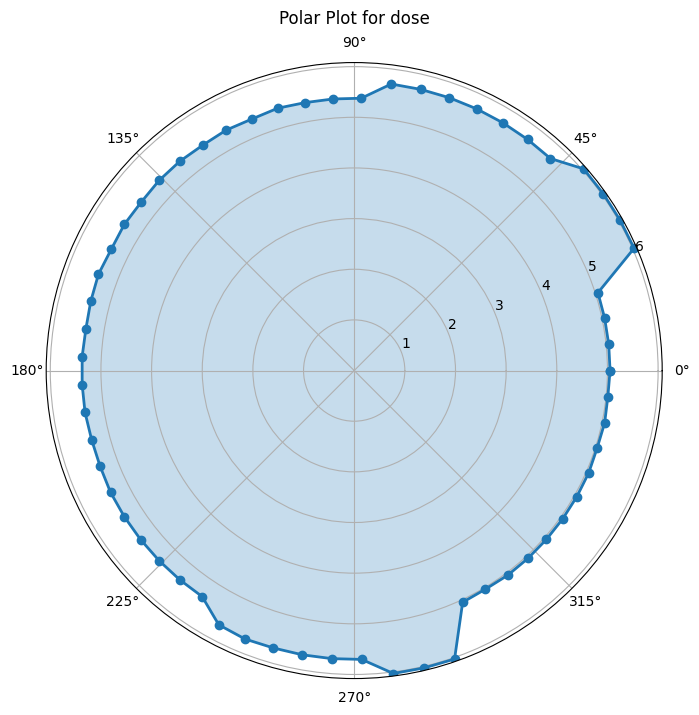

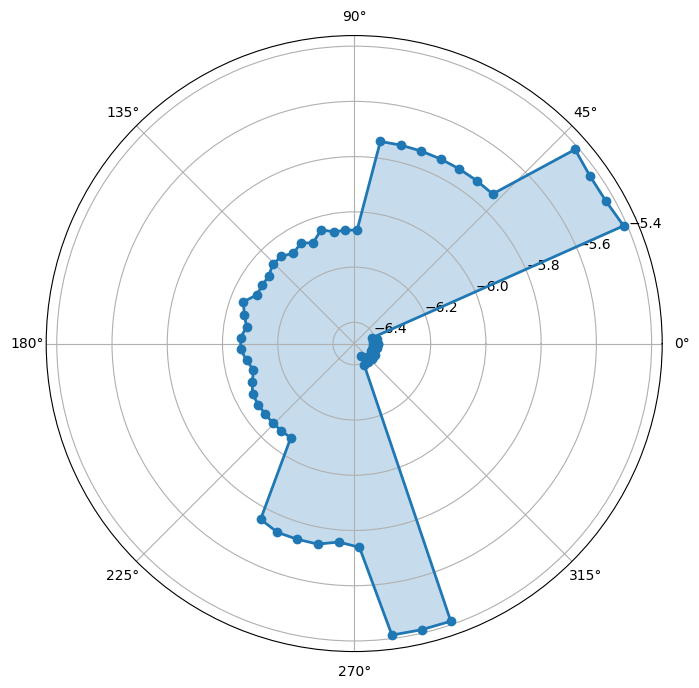

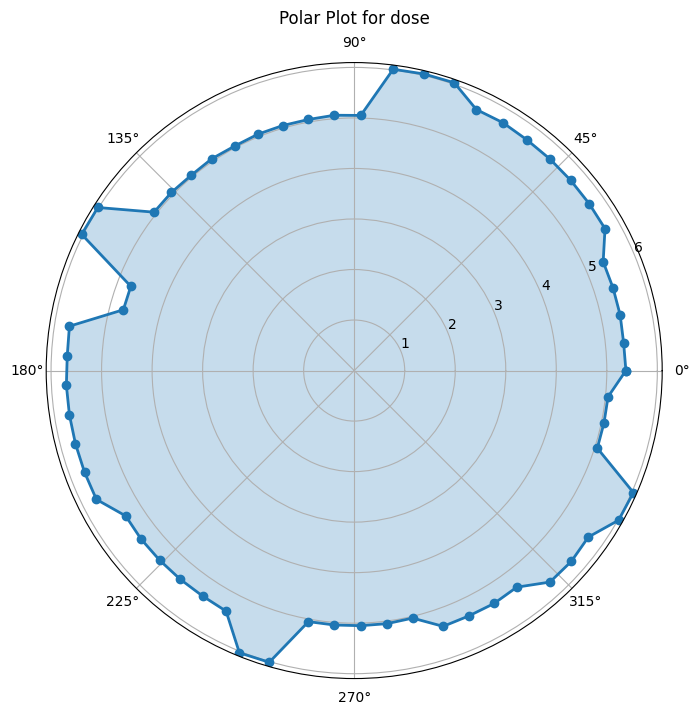

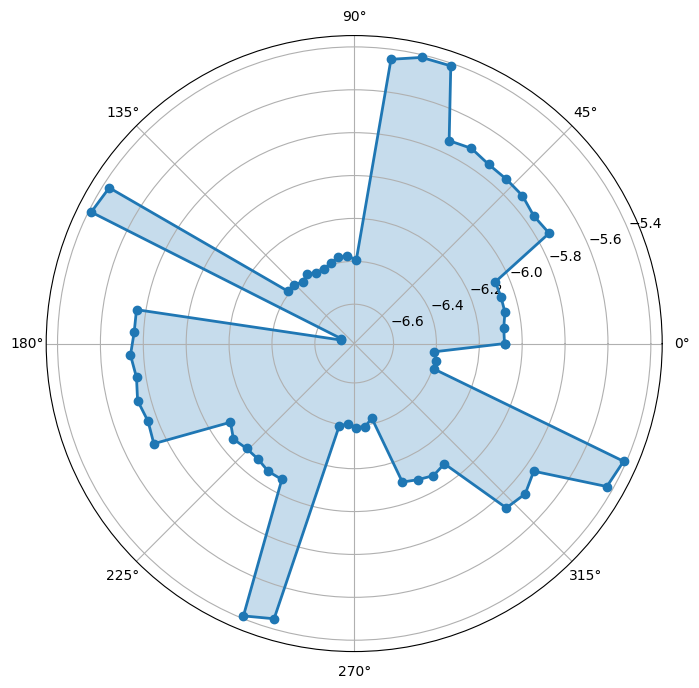

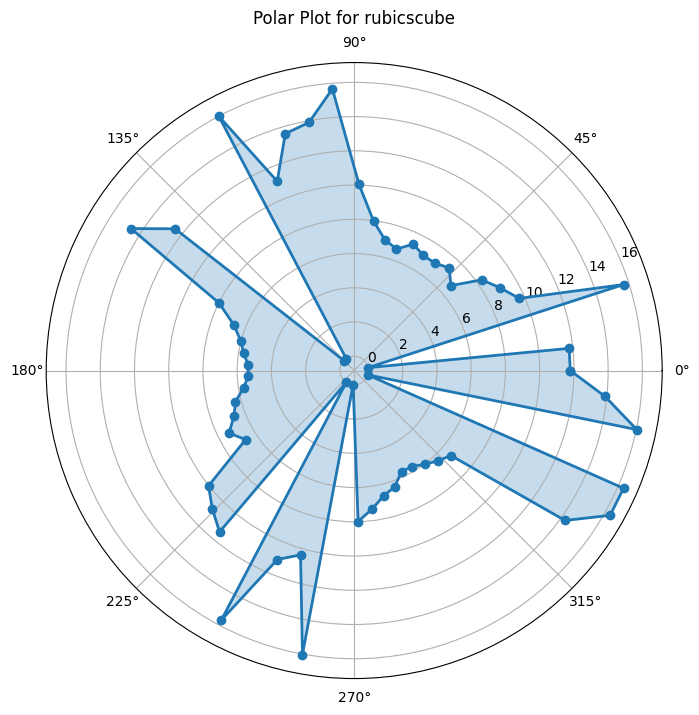

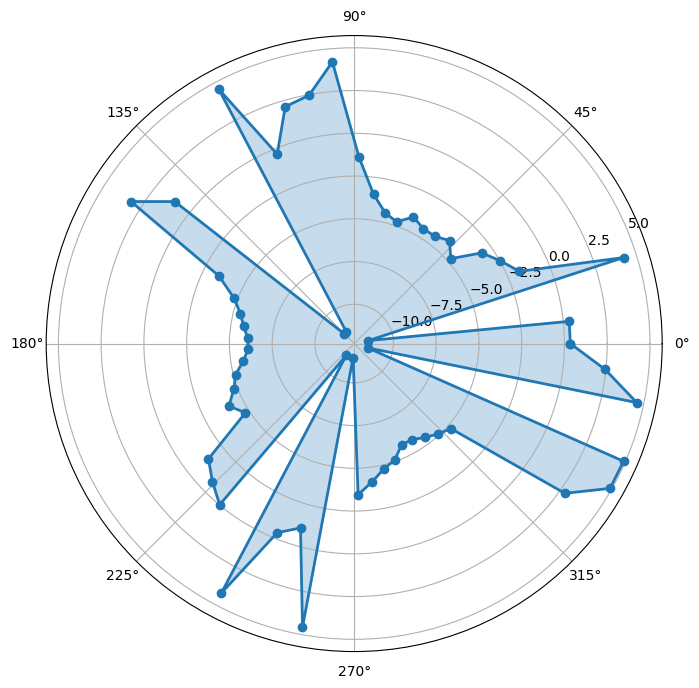

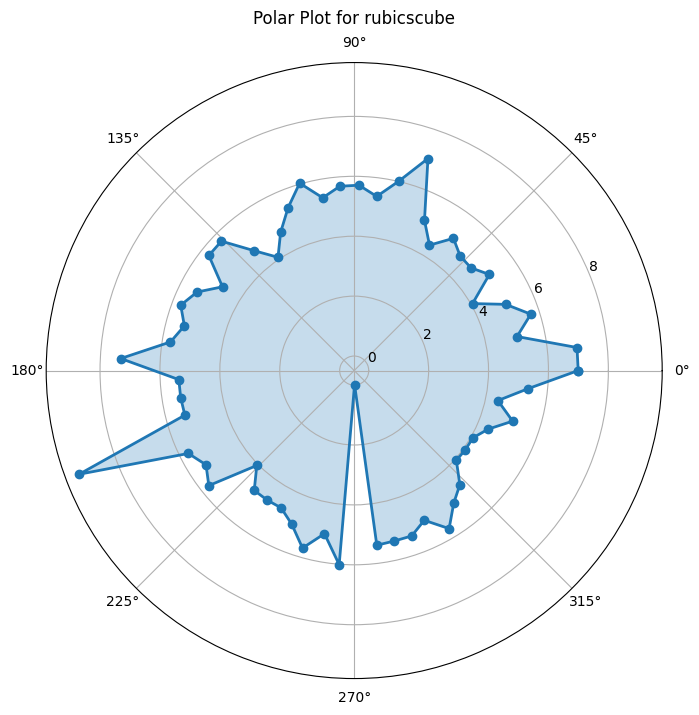

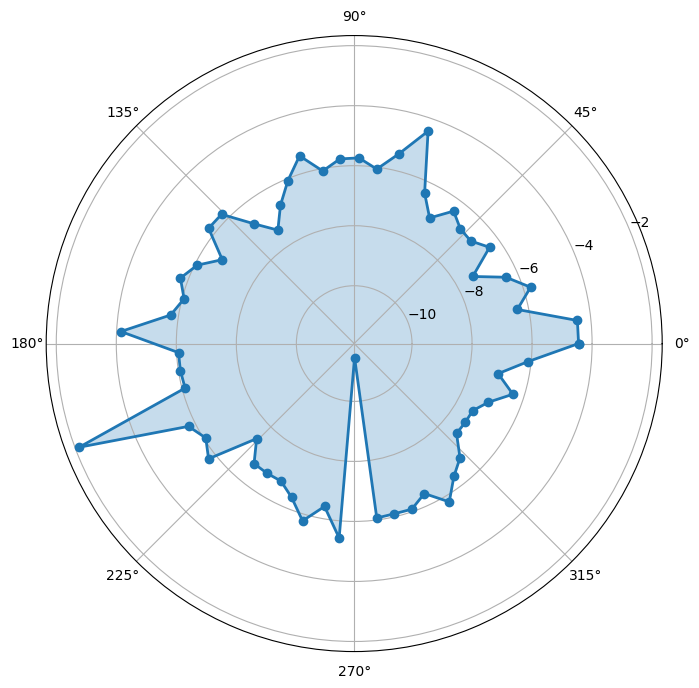

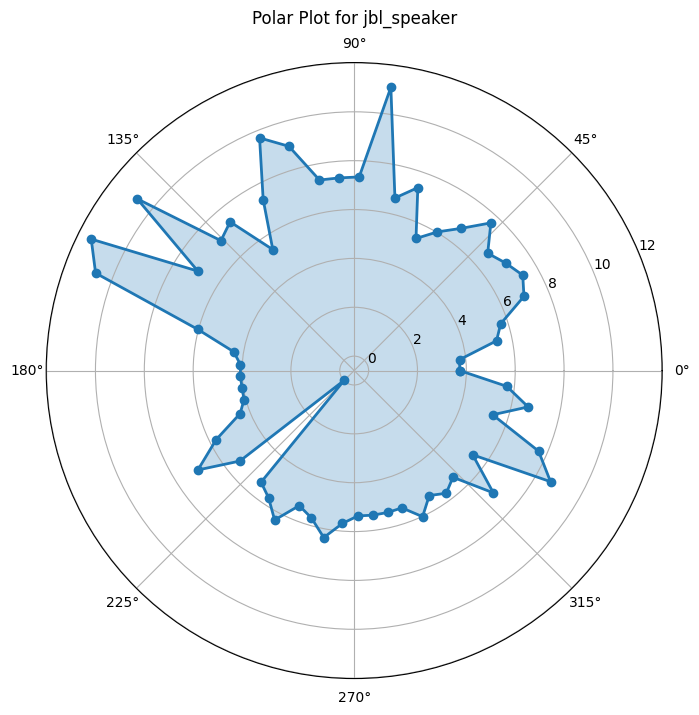

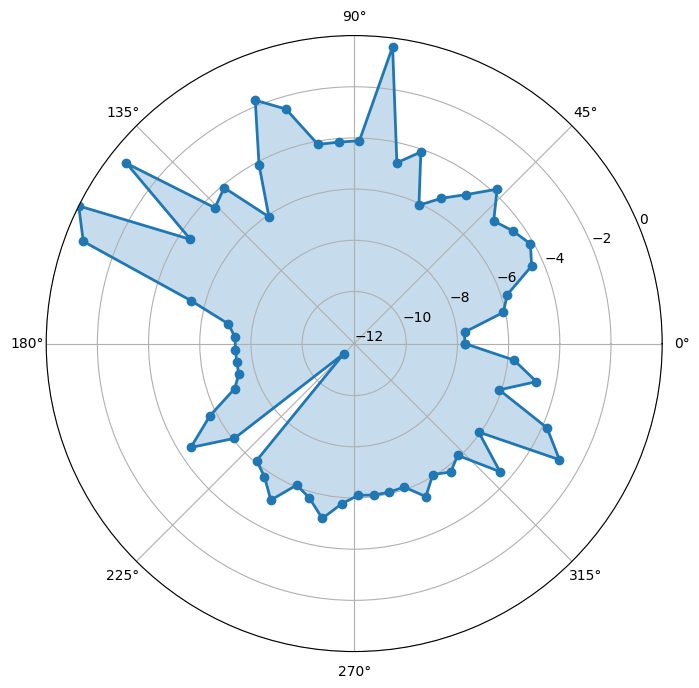

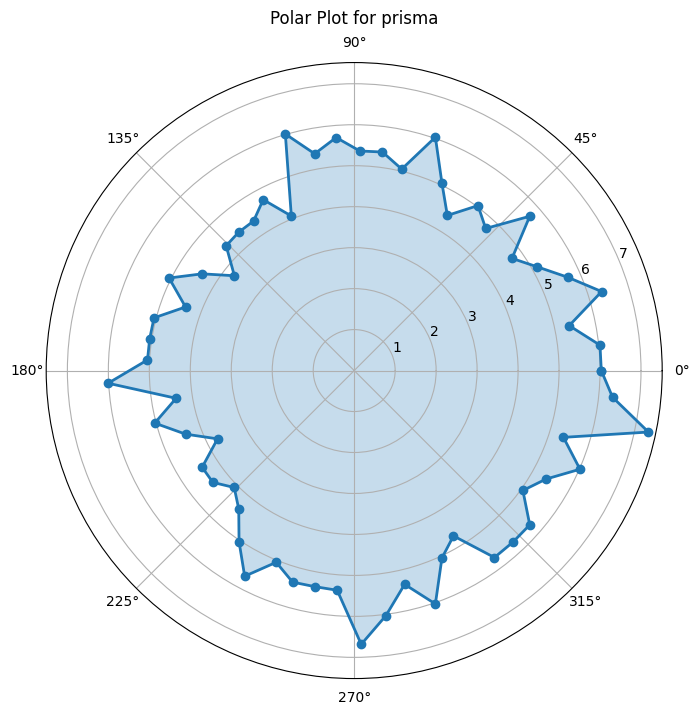

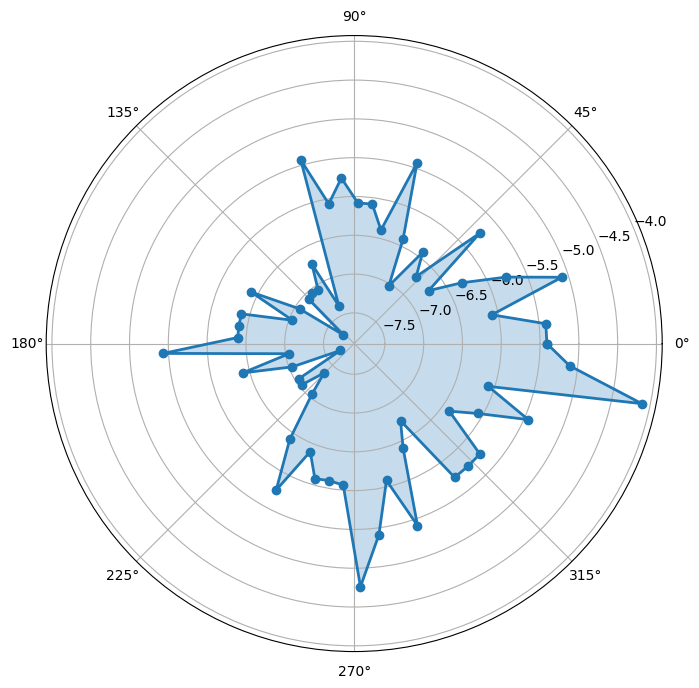

In [246]:

# plotting
def plot_polar_row_in_df(df):
    single_row = df.iloc[0]

    # Prepare the data for the polar plot
    angles = np.linspace(
        0, 2 * np.pi, 61, endpoint=False
    )  # Create 61 equally spaced angles
    angles = np.append(
        angles, angles[0]
    )  # Close the loop by appending the first angle at the end
    values = single_row.to_numpy()
    values = np.append(
        values, values[0]
    )  # Close the loop by appending the first value at the end

    # Create the polar plot
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values.T, "o-", linewidth=2)  # Plot the values
    ax.fill(angles, values.T, alpha=0.25)  # Fill the area under the curve
    pass


counter = 0
for i in range(len(df_list)):
    plot_polar_row_in_df(transform_data(df_list[i]))
    plt.title(f"Polar Plot for {label_list[i]}", va="bottom")
    plt.savefig(f"plots/{label_list[i]}_raw_data_{counter}.png")
    plt.show()
    
    plot_polar_row_in_df(df_list_transformed[i].iloc[:, :-1])
    plt.savefig(f"plots/{label_list[i]}_denoised_{counter}.png")
    plt.show()
    counter += 1

    pass



In [247]:
y = df_for_training['label']
X = df_for_training.drop('label', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75 , random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Anzahl der Ausgabeklassen
num_classes = len(label_encoder.classes_)

# Umwandlung der Labels in One-Hot-Encoding
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

In [248]:
model = Sequential([
                    Dense(64, activation='relu', input_shape=(X_train.shape[1],),),
                    Dropout(0.3),
                    Dense(64, activation='relu', ),
                    Dropout(0.3),
                    Dense(64, activation='relu', ),
                    Dropout(0.3),
                    Dense(num_classes, activation='softmax')  # anzahl der ausgabeneuronen entspricht anzahl der klassen
                    ])

# Kompilieren des Modells
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training des Modells
history = model.fit(X_train, y_train_categorical, epochs=50, batch_size=32, validation_data=(X_test, y_test_categorical))

#plotten von verlust und genauigkeitskurve

train_loss = history.history['loss']
validation_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochen = range(1, len(train_loss) +1)


Epoch 1/50
26/26 [==============================] - 1s 13ms/step - loss: 3.3088 - accuracy: 0.2916 - val_loss: 1.2939 - val_accuracy: 0.3072
Epoch 2/50
26/26 [==============================] - 0s 5ms/step - loss: 1.6116 - accuracy: 0.3742 - val_loss: 1.1879 - val_accuracy: 0.5597
Epoch 3/50
26/26 [==============================] - 0s 5ms/step - loss: 1.3390 - accuracy: 0.4399 - val_loss: 1.1659 - val_accuracy: 0.5771
Epoch 4/50
26/26 [==============================] - 0s 5ms/step - loss: 1.2232 - accuracy: 0.4933 - val_loss: 1.1075 - val_accuracy: 0.5747
Epoch 5/50
26/26 [==============================] - 0s 5ms/step - loss: 1.2278 - accuracy: 0.5200 - val_loss: 1.0634 - val_accuracy: 0.5832
Epoch 6/50
26/26 [==============================] - 0s 5ms/step - loss: 1.1443 - accuracy: 0.5298 - val_loss: 1.0168 - val_accuracy: 0.5779
Epoch 7/50
26/26 [==============================] - 0s 5ms/step - loss: 1.1049 - accuracy: 0.5504 - val_loss: 0.9854 - val_accuracy: 0.5900
Epoch 8/50
26/26 [=

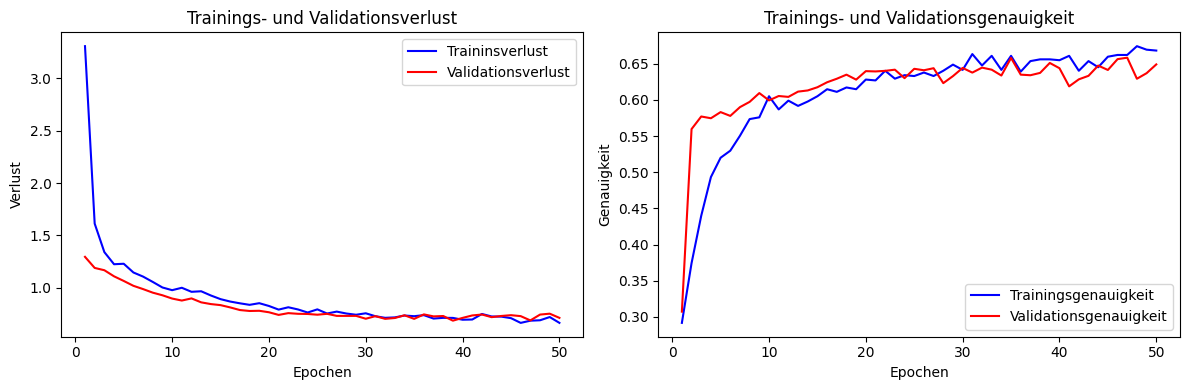

In [249]:
plt.figure(figsize=(12,4))


#verlust plot
plt.subplot(1, 2, 1)
plt.plot(epochen, train_loss, 'b-', label= "Traininsverlust")
plt.plot(epochen, validation_loss, 'r-', label= "Validationsverlust")
plt.title('Trainings- und Validationsverlust')
plt.xlabel('Epochen')
plt.ylabel('Verlust')
plt.legend()


#genauigkeit plot
plt.subplot(1,2,2)
plt.plot(epochen, train_accuracy, 'b-', label= "Trainingsgenauigkeit")
plt.plot(epochen, validation_accuracy, 'r-', label= "Validationsgenauigkeit")
plt.title('Trainings- und Validationsgenauigkeit')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.legend()


plt.tight_layout()
plt.show()

Trainingsgenauigkeit:  0.7278250303766707


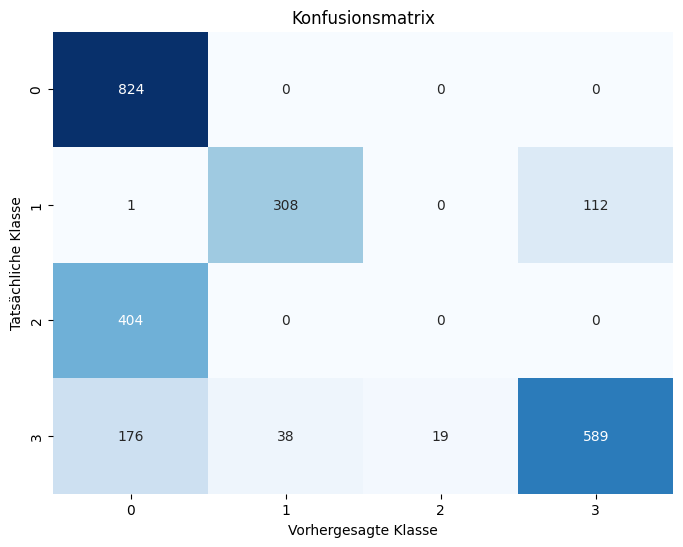

              precision    recall  f1-score   support

        dose       0.59      1.00      0.74       824
 jbl_speaker       0.89      0.73      0.80       421
      prisma       0.00      0.00      0.00       404
  rubicscube       0.84      0.72      0.77       822

    accuracy                           0.70      2471
   macro avg       0.58      0.61      0.58      2471
weighted avg       0.63      0.70      0.64      2471



In [250]:


model = make_pipeline(StandardScaler(), SVC())

model.fit(X_train, y_train)

# Mache Vorhersagen auf den Trainingsdaten
y_train_pred = model.predict(X_train)

# Berechne die Trainingsgenauigkeit
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Trainingsgenauigkeit: ", train_accuracy)

# Mache Vorhersagen auf den Testdaten
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Konfusionsmatrix')
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Tatsächliche Klasse')
# plt.xticks(["dose", "jbl", "prisma", "rubicscube"])
# plt.yticks(["dose", "jbl", "prisma", "rubicscube"])
plt.show()

print(classification_report(y_test, y_pred))


In [251]:
model = SVC(probability=True)

# Then fit the model to your data
model.fit(X_train, y_train)


def make_prediction(new_measurement_preprocessed):
    # Assuming the model has already made a prediction
    predicted_category = model.predict(new_measurement_preprocessed)

    # When you only need the probability of the predicted class
    probabilities = model.predict_proba(new_measurement_preprocessed)
    # Get the index of the predicted class in the model's classes_
    class_index = list(model.classes_).index(predicted_category[0])
    # Use this index to access the corresponding probability
    predicted_prob = probabilities[0][class_index]
    return (predicted_category, predicted_prob)

neuen_daten = pd.read_csv(directory + dose_3, header=None)

unknown_measurement_list = []

# for i in range(len(df_list)):
#     temp_df_transformed = transform_data(df_list[i])
#     temp_df_denoised = denoise(temp_df_transformed, df_noise_transformed)
#     # temp_df_denoised['label'] = label_list[i]
#     unknown_measurement_list.append(temp_df_denoised)

temp_df_transformed = transform_data(neuen_daten)
temp_df_denoised = denoise(temp_df_transformed, df_noise_transformed)
# temp_df_denoised['label'] = label_list[i]
unknown_measurement_list.append(temp_df_denoised)

for i in range(len(unknown_measurement_list)):
    predicted_category, predicted_prob = make_prediction(unknown_measurement_list[i])
    print(f"Predicted category: {predicted_category[0]} with confidence: {predicted_prob * 100:.2f}%")
    print(f"acutal object: {label_list[i]}")


Predicted category: dose with confidence: 93.13%
acutal object: dose
